# Ilustrative example

In this example we are going to introduce a basic example of how to obtain a solution and generate a ranking of variables importance based on the FPs method presented in the preprint [Optimal probabilistic feature shifts for reclassification in tree ensembles](https://arxiv.org/abs/2412.03722) by Víctor Blanco, Alberto Japón, Justo Puerto and Peter Zhang.

## 1. Setting up the problem

For this example we are going to work on a RandomForest Classifier in the "Pen-Based Recognition of Handwritten Digits" dataset of the UCI Mahine learning repository. For this, we will first import the necessary libraries, our auxiliary functions and load the data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo

import pfs_auxiliar_functions as aux

In [2]:
pen_based_recognition_of_handwritten_digits = fetch_ucirepo(id=81)

# data (as pandas dataframes)
X = pen_based_recognition_of_handwritten_digits.data.features
y = pen_based_recognition_of_handwritten_digits.data.targets

X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0


In [3]:
y.head()

,Class
0,8
1,2
2,1
3,4
4,1


Once the data have been read, we must scale the continuous predictors to the range [0,1]. In addition, we must define which, based on the context of our experiment, is the desired class. In this example, we will consider an odd value in the original target variable as the desired class.

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(X)
X = pd.DataFrame(scaled_values, columns=X.columns)

y = y.squeeze()
y = y % 2

X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16
0,0.47,1.00,0.27,0.81,0.57,0.37,0.26,0.00,0.00,0.23,0.56,0.53,1.00,0.90,0.40,0.98
1,0.00,0.89,0.27,1.00,0.42,0.75,0.29,0.45,0.15,0.15,0.37,0.00,0.69,0.02,1.00,0.06
2,0.00,0.57,0.31,0.68,0.72,0.90,1.00,1.00,0.76,0.75,0.50,0.51,0.28,0.25,0.16,0.00
3,0.00,1.00,0.07,0.92,0.05,0.68,0.19,0.45,0.86,0.34,1.00,0.45,0.74,0.23,0.67,0.00
4,0.00,0.67,0.49,0.83,1.00,1.00,0.81,0.80,0.60,0.60,0.40,0.40,0.33,0.20,0.47,0.00


In [5]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Class, dtype: int64

Once the objective of the analysis has been established, an analysis must be made of how the predictor variables affect the objective variable, which predictor variables are immutable, and which variables may require special treatment. Note that there are many different ways of approaching this problem, and the researcher must decide in each case how to proceed.

For this example, we will collect in the variables_information list the positive (+1) or negative (-1) effect of each predictor variable on the target variable according to the pointbiserialr function of the scipy.stats library.

In [6]:
from scipy.stats import pointbiserialr

variables_information = [1 if pointbiserialr(X.iloc[:, j], y)[0] > 0 else -1 for j in range(X.shape[1])]
        
variables_information

[-1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]

Finally, one would have to obtain the classifier. As in the previous case, one can design this step as desired, making the necessary data set partitions and estimating the parameters. For this illustrative example, we will use the entire data set and set the forest size to 25 trees of depth 5 as described in the paper.

In [7]:
n_trees = 25
depth = 5
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=depth)
rf.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=25)

## 2. Obtaining a solution for one individual

Once we have the classifier trained, the next step is to match the classifier information to the environment we use to solve the MINLP. For this, we use the auxiliary functions.

In [8]:
leaves, trees_vars, trees_vals = aux.build_forest(rf, n_trees=25, depth=5)

Now we select as an example the first idividual in the sample, which as we saw at the beginning does not belong to the desired class, and adapt it to MINLP's input format (i.e., last value represents the class).

In [9]:
individual = pd.DataFrame(X.iloc[0,:]).transpose()
individual["y"] = y.iloc[0]
individual

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,y
0,0.47,1.0,0.27,0.81,0.57,0.37,0.26,0.0,0.0,0.23,0.56,0.53,1.0,0.9,0.4,0.98,0


After this we calculate the probabilities of change, with and without effort, that the individual has in each of the nodes of the forest trees. We do this according to the paper by calculating the maximum deviations in the variables and simulating over 1000 random scenarios.

In [10]:
desv, desv_eff = aux.calculate_deviations(X, variables_information)
probs, probs_eff = aux.calculate_forest_probs(individual.iloc[0,:-1], rf, n_trees, depth, desv, desv_eff, variables_information,
                                              n_iters = 1000)

Finally, we set the number of variables that we are going to allow with effort and solve the MINLP we want. In this example we use C = 3 and solve the max-path problem.

In [11]:
import pfs_model_max as pfs_max
C = 3
pfs_x_sol, z_sol , beta_sol, time, gap = pfs_max.pfs(individual, C, probs, probs_eff, trees_vars, trees_vals, depth, leaves,
                                                     timelimit=300)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-22
Set parameter TimeLimit to value 300
Set parameter NumericFocus to value 1
Set parameter OptimalityTol to value 1e-06
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
IntFeasTol  1e-06
NumericFocus  1

Optimize a model with 82583 rows, 36491 columns and 164954 nonzeros
Model fingerprint: 0x931d4f3e
Model has 25 function constraints treated as nonlinear
  25 LOG
Variable types: 34466 continuous, 2025 integer (2025 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+01]
         Setting lower bound to 1e-10.
Presolve removed 76392 rows and 33956 columns
Presolve time: 0.08

Note that in order to obtain the list of variables on which the individual must put effort, it is necessary to work with the solution of the beta variables of the model. These variables are activated when effort is put on the variable of a node of a tree of the forest.

In [12]:
effort_vars = [1 if x > 1 else 0 for x in np.sum(beta_sol,axis=0)]
effort_vars

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

In [13]:
[i+1 for i in range(len(effort_vars)) if effort_vars[i]>0.5]

[2, 10, 13]

As a result, effort should be applied to attributes 2, 10 and 13.

## 3. Creating a ranking of variables importance 

As in our case study, the researcher may be interested in obtaining a ranking of variables importance for an entire population. The option we follow in the case study of the paper is to solve the problem for all individuals that do not belong to the desired class and establish a ranking based on which variables are most often selected in the final solution. For this, the following functions that we have prepared, that calculate the probability estimation and solve the problem for all individuals, can be used. For the sake of simplicity, in this example we will use only the first 10 individuals of the dataset.

In [14]:
# Reduce data for example
X = X.iloc[10:20,:]
y = y[10:20]

In [16]:
ordered_ranking, ranking, list_vars_eff = aux.pfs_ranking(X, y, variables_information, rf, n_trees, depth, C, model=3, 
                                                          timelimit=60, n_iter=1000, kappa=0.5)

# model: 1(max-path) - 2 (min-path) - 3 (kappa-path) 

  0%|          | 0/10 [00:00<?, ?it/s]

Set parameter TimeLimit to value 60
Set parameter NumericFocus to value 1
Set parameter OptimalityTol to value 1e-07
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  60
IntFeasTol  1e-07
OptimalityTol  1e-07
NumericFocus  1

Optimize a model with 109758 rows, 62891 columns and 290931 nonzeros
Model fingerprint: 0xc4ed88da
Model has 25 function constraints treated as nonlinear
  25 LOG
Variable types: 35266 continuous, 27625 integer (27625 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 1e+02]
         Setting lower bound to 1e-10.
Presolve removed 99296 rows and 36312 columns
Presolve time: 0.26s
Presolved: 10587 rows, 26580 columns, 79527 nonzeros
Presolved mode

Text(0.5, 0, 'PFS Importance')

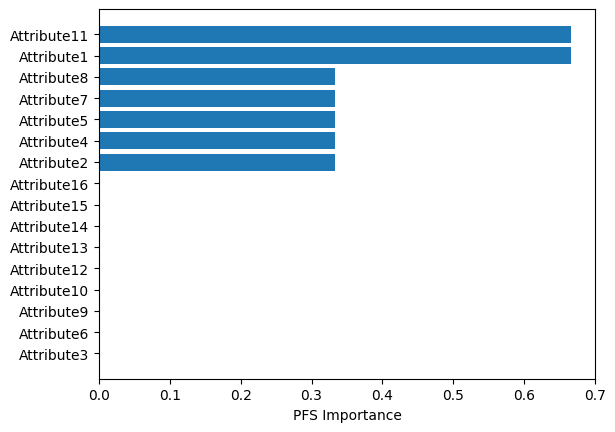

In [17]:
plt.barh(ordered_ranking.columns, ordered_ranking.values[0])
plt.xlabel("PFS Importance")